# Setup of Noteboook

The follwing code clones the github repository with course files. 
Subsequently it imports all libraries and custom modules needed for this notebook

In [1]:
!git clone https://github.com/DataHow/analytics-course-scripts.git
!pip install bayesian-optimization

Cloning into 'analytics-course-scripts'...
remote: Enumerating objects: 450, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 450 (delta 3), reused 7 (delta 3), pack-reused 440
Receiving objects: 100% (450/450), 13.75 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (274/274), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import libraries
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.stats import norm
from bayes_opt import BayesianOptimization, UtilityFunction

from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
from matplotlib import gridspec


# Bayesian Optimization using Gaussian Processes

If every function evaluation is expensive, for instance when the parameters are the hyperparameters of a neural network and the function evaluation is the mean cross-validation score across ten folds, optimizing the hyperparameters by standard optimization routines would take for ever!

The idea is to approximate the function using a Gaussian process. In other words the function values are assumed to follow a multivariate gaussian. The covariance of the function values are given by a GP kernel between the parameters. Then a smart choice to choose the next parameter to evaluate can be made by the acquisition function over the Gaussian prior which is much quicker to evaluate.



## Problem Definition

We are interested in solving

\begin{align}x^* = arg \min_x f(x)\end{align}

under the constraints that:

*   $f$ is a black box for which no closed form is known (nor its gradients)
*   $f$ is expensive to evaluate
*   evaluations of $y=f(x)$ may be noisy





# Create function to optimize

Here we first create an originator function that's nonlinear with addition of noise.

In [3]:
""" Fix seed to control randomness """
SEED = np.random.seed(42)
""" Noise in function observations """
EPS = 0.5
""" Define initial experimental points locations """
#XPOINTS = np.array([-2.5, -1.8, -0.2, 0, 0.75, 1, 1.1, 1.4, 2.4, 2.5])
XPOINTS = np.arange(-2.5,0.5,0.5)

In [4]:
# Function definition

xgrid = np.round(np.arange(-3,3,0.01),4)
def f(x,eps=0):
    return -1*np.power(x,4)+0.5*np.power(x,3)+6*np.power(x,2)+0.5*np.power(x,1)-6+eps*np.random.normal(0,1,x.size)
fgrid = f(xgrid)
# Obtain observation measurments with noise
xpoints = XPOINTS
ypoints = f(xpoints,EPS)
# Plot funcition with measurments
maxloc = np.argmax(f(xgrid))
maxval = xgrid[maxloc]
maxfun = f(maxval)[0]
fig = go.Figure()
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash'),name='Unknown function'))
fig.add_trace(go.Scatter(x=xpoints,y=ypoints,mode='markers',marker=dict(size=10),name='Measurements'))
fig.add_trace(go.Scatter(x=[maxval,maxval],y=[-50,maxfun],mode='lines',line=dict(color='red',dash='dash'),name=f'Location of Maximum ({maxval})'))
fig.add_trace(go.Scatter(x=[-5,maxval],y=[maxfun,maxfun],mode='lines',line=dict(color='green',dash='dash'),name=f'Value at Maximum ({round(maxfun,3)})'))
fig.update_yaxes(range=[-20, 20])
fig.update_xaxes(range=[-3, 3])
fig.update_layout(title="Unknown function with measurments",xaxis_title="x",yaxis_title="y")
fig.show()

The goal is to find maximum. If we could sample unlimited times our datapoints x, we could just look up the answer. However, we have limited resources so we can sample only several experimental observations and approximate/model the behaviour in the remaining places

### Fit gaussian process model

We use gausian processes with standard normal kernel to learn the function above given those measurments.

In [5]:
# Define Model
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-2, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0, n_restarts_optimizer=3).fit(xpoints.reshape(-1,1), ypoints.reshape(-1,1)) 
# Use model to make predictions
xpred = xgrid
ypred = np.zeros((3,len(xpred)))
for n in range(len(xpred)):
    (mean,std)=gpr.predict(xgrid[n].reshape(-1,1),return_std=True) 
    ypred[1,n] = mean.flatten()
    ypred[0,n] = mean.flatten()-2*std.flatten()
    ypred[2,n] = mean.flatten()+2*std.flatten()

In [6]:
# Plot predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color=px.colors.qualitative.G10[3]),name='Mean prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color=px.colors.qualitative.G10[3]),showlegend=False))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color=px.colors.qualitative.G10[3]),fill='tonexty',name='Std prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color=px.colors.qualitative.G10[0]),name='Unknown function'))
fig.add_trace(go.Scatter(x=xpoints,y=ypoints,mode='markers',marker=dict(size=10,color=px.colors.qualitative.G10[1]),name='Measurements'))
fig.update_yaxes(range=[-20, 20])
fig.update_xaxes(range=[-3, 3])
fig.update_layout(title="Learned function from observations",xaxis_title="x",yaxis_title="y")
fig.show()

# Define acquisition function

Acquisition function represent our objective. This objective then guides us in finding the maximum value and location.




## Exploration / Exploitation

Simples acquisition function one can think of is to take the conditional mean. This fully tries to maximise/exploit the process. We can add the uncertainty estimate as exploration parameter to investigate also regions with higher uncertainty or few observation points.

You can define your own acquisition function. The function demonstrated below is a balanced approach between exploration and exploitation which is driven by parameter $\kappa$ = `kappa`. The values correspond to the upper confidence bounds.

\begin{align} UCB(x) = (1- \kappa)*\mu_{GP}(x) + \kappa * \sigma_{GP}(x)\end{align}


In [7]:
""" Exploration / Exploitation tradeoff """
KAPPA1 = 0.2
KAPPA2 = 0.7

In [8]:
# Calculate EE (Explore-Exploit)
eegrid1 = (1-KAPPA1)*ypred[1,:] + KAPPA1*((ypred[1,:]-ypred[0,:])/2)
eegrid2 = (1-KAPPA2)*ypred[1,:] + KAPPA2*((ypred[1,:]-ypred[0,:])/2)
# Plot acquisition function (EE)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color='green'),name='Mean prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color='green'),showlegend=False))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color='green'),fill='tonexty',name='Std prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color='blue'),name='Unknown function'))
fig.add_trace(go.Scatter(x=xpoints,y=ypoints,mode='markers',marker=dict(size=10,color='red'),name='Measurements'))
fig.add_trace(go.Scatter(x=xgrid,y=eegrid1,mode='lines',line=dict(color='black'),name=f'Explore-Exploit ({KAPPA1})'),secondary_y=True)
fig.add_trace(go.Scatter(x=xgrid,y=eegrid2,mode='lines',line=dict(color='red'),name=f'Explore-Exploit ({KAPPA2})'),secondary_y=True)
fig.update_xaxes(range=[-3, 3])
fig.update_yaxes(range=[-20, 50], secondary_y=False)
fig.update_yaxes( secondary_y=True,title_text="Explore-Exploit")
fig.update_layout(title="Acquisition function (Explore-Exploit) for all x",xaxis_title="x",yaxis_title="y")
fig.show()


## Probability of improvement.

Another example of good acquisition function is a probability of improvement.

\begin{align} PI(x) = 1-P(f(x)\geq f(x_t^+ + \kappa)) \end{align}

To demonstrate it, let's evaluate the function at some new point. Then, we compare this prediction with actual maximal value observed so far.

In [9]:
""" New evaluation points  """
XNEW = 1.5

In [10]:
# Obtain prediction at the new point
xnew = XNEW
(xnew_mean,xnew_std) = gpr.predict(np.array(xnew).reshape(1,-1),return_std=True)
print('Predicted mean and std at x = '+str(xnew))
print("Mean: ",float(xnew_mean))
print("Std: ",float(xnew_std))

# Actual maximum value
y_max = np.max(ypoints)
print("Observed maximum function value so far at y = "+str(round(y_max,4)))

Predicted mean and std at x = 1.5
Mean:  8.662260233463485
Std:  12.043285943528254
Observed maximum function value so far at y = 0.4348


### Compute distribution

Therefore we compute distribution of possible values. Since we know our prediction at each new point `xnew` is normally distributed with `xnew_mean` and `xnew_std`, we can plot the full distribution at the new point. 

This distribution represents possible observations according to the model. The solid red line represents a so far actualy observed maximum value `y_max`.

Now we compute the accquisition function based on the conditional probability distribution as probability of improvement. That is a probability of observing a value from the conditional distribution greater than the observed maximum value is:



In [11]:
# Compute normal distribution
xdist = np.random.randn(100000)*float(xnew_std) + float(xnew_mean)
hist_data = [xdist]
group_labels = ['Conditional Distribution'] 
# Probability of improvement
PI = 1-norm(float(xnew_mean), float(xnew_std)).cdf(y_max)
# Plot distribution
fig = ff.create_distplot(hist_data, group_labels,curve_type='normal',show_hist=False, show_rug=False)
fig.add_vline(x=float(xnew_mean),line=dict(color='green'),annotation=dict(text="Mean",textangle=90))
fig.add_vline(x=float(xnew_mean)+float(xnew_std),line=dict(color='green',dash='dash'),annotation=dict(text="Std",textangle=90))
fig.add_vline(x=float(xnew_mean)-float(xnew_std),line=dict(color='green',dash='dash'),annotation=dict(text="Std",textangle=90))
fig.add_vline(x=float(y_max),line=dict(color='red'),annotation=dict(xanchor="right",text="Observed Maximum Value",textangle=90))
fig.add_trace(go.Scatter(x=[y_max,y_max,max(hist_data[0]),max(hist_data[0]),y_max],y=[0,max(fig.data[0]['y']),max(fig.data[0]['y']),0,0],mode='lines',line=dict(color='lightgoldenrodyellow'),name=f"Probability of Improvement {round(PI,3)}",fill='toself'))
fig.update_layout(title="Conditional distribution at x = "+str(xnew),showlegend=True,xaxis_title="x",yaxis_title="pdf")
fig.show()


### Compute acquisition for all x

Now we compute the acquisition function for all x values


In [12]:
# Calculate PI (Probability of Improvement)
pigrid = np.zeros_like(xgrid)
for n in range(len(xgrid)):
    pigrid[n] = 1-norm(float(ypred[1,n]), float((ypred[1,n]-ypred[0,n])/2)).cdf(y_max)
# Plot acquisition function (PI)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color='green'),name='Mean prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color='green'),showlegend=False))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color='green'),fill='tonexty',name='Std prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color='blue'),name='Unknown function'))
fig.add_trace(go.Scatter(x=xpoints,y=ypoints,mode='markers',marker=dict(size=10,color='red'),name='Measurements'))
fig.add_trace(go.Scatter(x=xgrid,y=pigrid,mode='lines',line=dict(color='red'),name='Probability of Improvement'),secondary_y=True)
fig.update_xaxes(range=[-3, 3])
fig.update_yaxes(range=[-20, 20], secondary_y=False)
fig.update_yaxes(range=[0,1], secondary_y=True,title_text="Probability of Improvement")
fig.update_layout(title="Acquisition function (Probability of Improvement) for all x",xaxis_title="x",yaxis_title="y")
fig.show()


Given the defined acquisition function, then next point we would like to observe a measurment from is value for which the acquisition function is the highest.

## Expected improvement

Here we modify our acquisition function to be an expected improvement. That is an actual value of the function by which we expect to improve discounted by their conditional probabilities.

\begin{align} EI(x) = E\left[ f(x) - f(x_t^+) - \kappa \right]\end{align}


In [13]:
# Calculate EI (Expected Improvement)
eigrid = np.zeros_like(xgrid)
xi = 0.1
for n in range(len(xgrid)):
    sigma = float((ypred[1,n]-ypred[0,n])/2)
    zscore = (float(ypred[1,n])-y_max-xi) / sigma
    C = norm(0,1).cdf(zscore)
    P = norm(0,1).pdf(zscore)
    eigrid[n] = (float(ypred[1,n])-y_max-xi)*C + sigma*P

In [14]:
# Plot acquisition function (EI)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color='green'),name='Mean prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color='green'),showlegend=False))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color='green'),fill='tonexty',name='Std prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color='blue'),name='Unknown function'))
fig.add_trace(go.Scatter(x=xpoints,y=ypoints,mode='markers',marker=dict(size=10,color='red'),name='Measurements'))
fig.add_trace(go.Scatter(x=xgrid,y=eigrid,mode='lines',line=dict(color='red'),name=f'Expected Improvement (xi={xi})'),secondary_y=True)
fig.update_xaxes(range=[-3, 3])
fig.update_yaxes(range=[-20, 20], secondary_y=False)
fig.update_yaxes( secondary_y=True,title_text="Expected Improvement")
fig.update_layout(title="Acquisition function (Expected Improvement) for all x",xaxis_title="x",yaxis_title="y")
fig.show()


# Run Bayesian Optimization

Now that we have have defined the optimization problem, we can run the bayesian optimization and see if we are able to iteratively find the maximum possible value.


## Target function

Lets create a target 1-D function with multiple local maxima to test and visualize how the BayesianOptimization package works. The target function we will try to maximize is the following:

\begin{align} f_1(x) = -1x^4 + 0.5x^3 + 6x^2+ 0.5x-6 +\epsilon \end{align}
\begin{align} f_2(x) = e^{-(x-2)^2} + e^{-0.1(x-6)^2}+ 1/(x^2+1)\end{align}

the maximum of both is around $x=2$ and we will restrict the interval of interest to $x_{f_1} \in (-3,3)$ and $x_{f_2} \in (-2,10)$

Notice that, in practice, this function is unknown, the only information we have is obtained by sequentialy probing it at different points. Bayesian Optimization works by contructing a posterior distribution of functions that best fit the data observed and chosing the next probing point by balancing exploration and exploitation.

In [15]:
""" Noise level """
EPS = 0.5
""" Function to optimize """
def f(x,eps=0.5):
    x = np.array(x)
    return -1*(x**4)+0.5*(x**3)+6*(x**2)+0.5*x-6 + eps*np.random.normal(0,1,x.shape) # domain (-3,3)
    #return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)   # domain (-2,10)
    #return np.sin(x)/2 - ((10 - x)**2)/50 + 2 # use domain (0,20)
""" Domain / range of values"""
domain = (-3,3)
#domain = (-2,10)
#domain = (0,20)

In [16]:
xgrid = np.linspace(domain[0],domain[1],1000)
# Plot true function
fig = go.Figure()
fig.add_trace(go.Scatter(x=xgrid,y=f(xgrid,eps=0).flatten(),mode='lines',line=dict(dash='dash')))
fig.show()

Enter the target function to be maximized, its variable(s) and their corresponding ranges. A minimum number of 2 initial guesses is necessary to kick start the algorithms, these can either be random or user defined.

In [21]:
# Define model
#kernel = Matern(length_scale=1.0)
#regressor = GaussianProcessRegressor(kernel=kernel)

# Define optimizer
optimizer = BayesianOptimization(f, {'x': domain}, random_state=42,verbose=2)
optimizer._gp.set_params(**dict(alpha=1))
optimizer.maximize( n_iter=30)


|   iter    |  target   |     x     |
-------------------------------------
| 1         | -2.653    | -0.7528   |
| 2         | -4.248    | 2.704     |
| 3         | 5.012     | 1.392     |
| 4         | -3.705    | 0.592     |
| 5         | -4.071    | -2.064    |
| 6         | 3.789     | 1.365     |
| 7         | 4.396     | 1.594     |
| 8         | 7.091     | 1.91      |
| 9         | -48.5     | -3.0      |
| 10        | -17.64    | 3.0       |
| 11        | -6.298    | -0.0273   |
| 12        | -0.9227   | 0.9395    |
| 13        | -1.294    | -1.11     |
| 14        | 6.698     | 1.948     |
| 15        | 6.672     | 1.94      |
| 16        | 7.001     | 1.919     |
| 17        | 4.571     | 1.387     |
| 18        | 6.66      | 2.085     |
| 19        | 0.8745    | -1.369    |
| 20        | 6.649     | 1.658     |
| 21        | 6.335     | 2.134     |
| 22        | 5.685     | 1.579     |
| 23        | -5.043    | -0.4214   |
| 24        | 6.676     | 2.091     |
| 25        

## Convergence plot

In [22]:
func_vals = [out['target'] for out in optimizer.res]
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,len(func_vals)+1)),y=np.maximum.accumulate(func_vals)))
fig.update_layout(title=f"Convergence Plot <br><sup> Optimal point found by optimizaiton at x = {round(optimizer.max['params']['x'],4)} <br> Functional value at optimum f(x) = {round(optimizer.max['target'],4)}",xaxis_title="Number of iterations", yaxis_title="max f(x) after n iterations </sup> ")

## Acquisition function progression

In [23]:
# Define plotting functions
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((domain[0], domain[1]))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((domain[0], domain[1]))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)



Define Optimization we investigate sequentially

In [24]:
# Plot defaults
x = xgrid.reshape(-1, 1)
y = f(xgrid,eps=0)
# Define Optimization
optimizer = BayesianOptimization(f, {'x': domain}, random_state=1,verbose=2)
optimizer.maximize(init_points=2, n_iter=0)
# Modify Model
kernel=Matern(length_scale=1, nu=2.5, length_scale_bounds=(1e-3,1e3))
optimizer._gp.set_params(**dict(alpha=0.1,kernel=kernel))


|   iter    |  target   |     x     |
-------------------------------------
| 1         | -4.751    | -0.4979   |
| 2         | 2.882     | 1.322     |


GaussianProcessRegressor(alpha=0.1, kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=RandomState(MT19937) at 0x7FE97B22AA40)

### Two random points

After we probe two points at random, we can fit a Gaussian Process and start the bayesian optimization procedure. Two points should give us a uneventful posterior with the uncertainty growing as we go further from the observations.

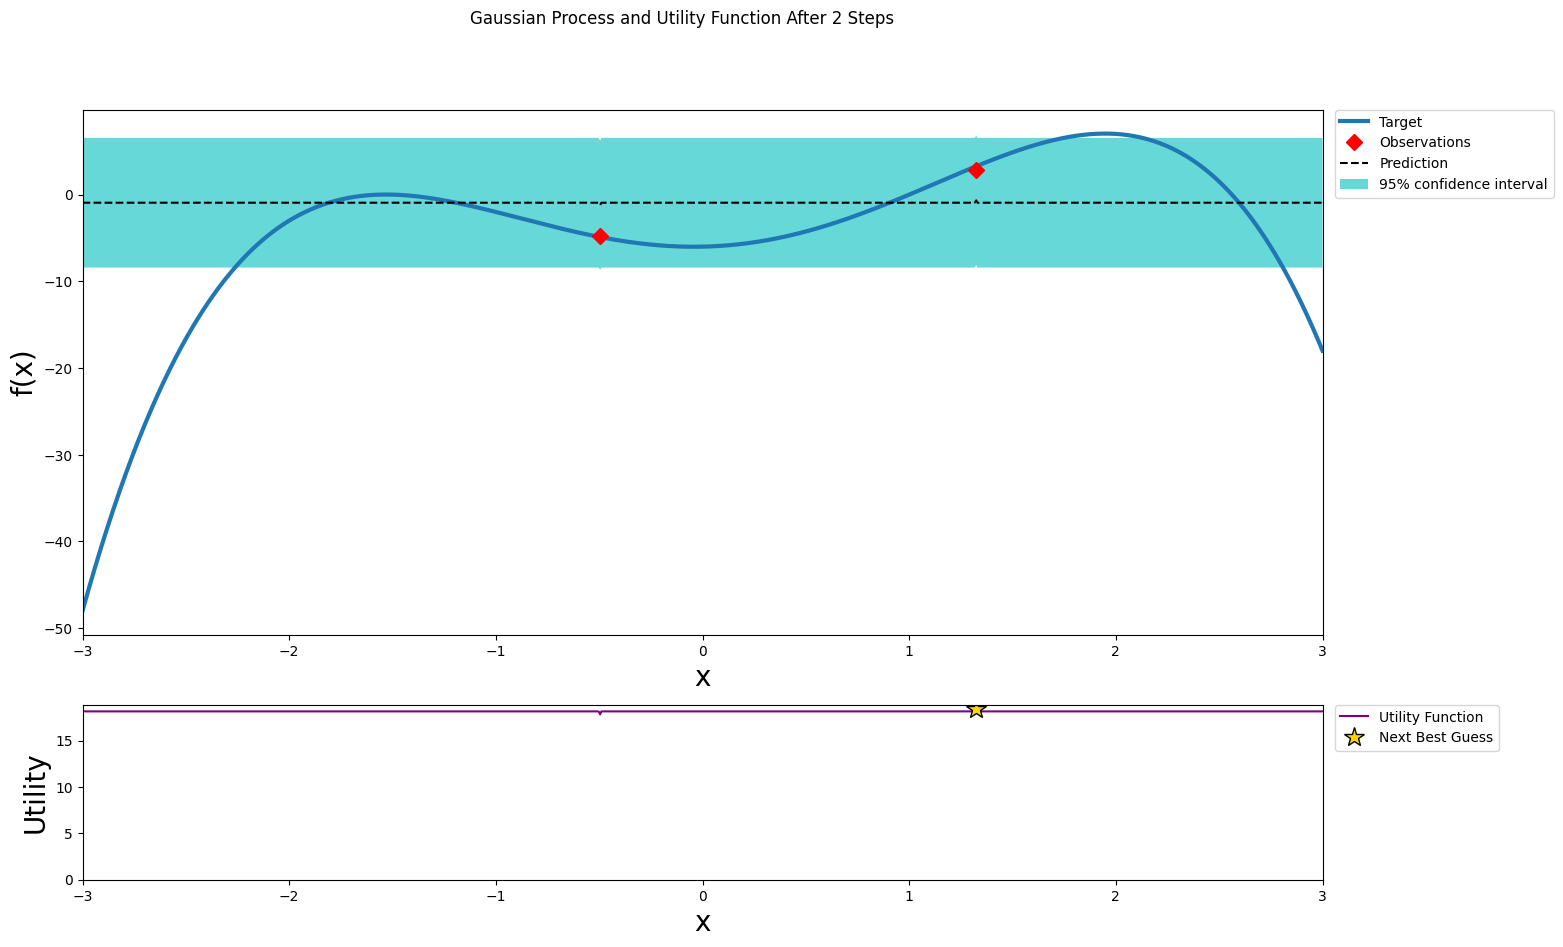

In [25]:
plot_gp(optimizer, x, y)

### After one step of GP

|   iter    |  target   |     x     |
-------------------------------------
| 3         | 3.166     | 1.327     |


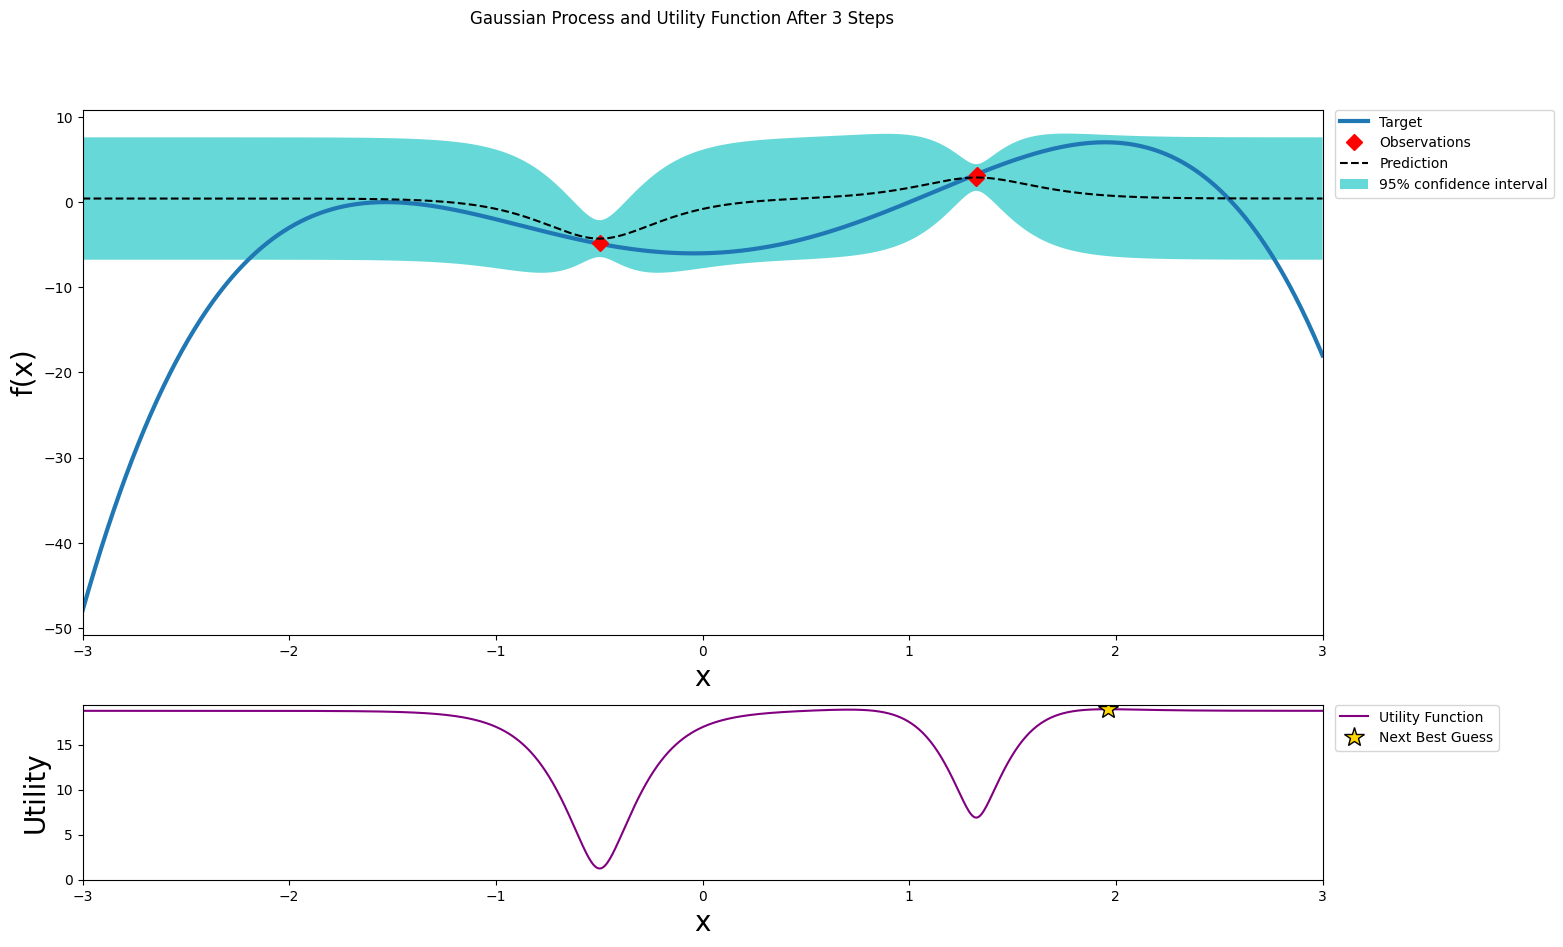

In [26]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

### After two steps of GP

|   iter    |  target   |     x     |
-------------------------------------
| 4         | 6.925     | 1.818     |


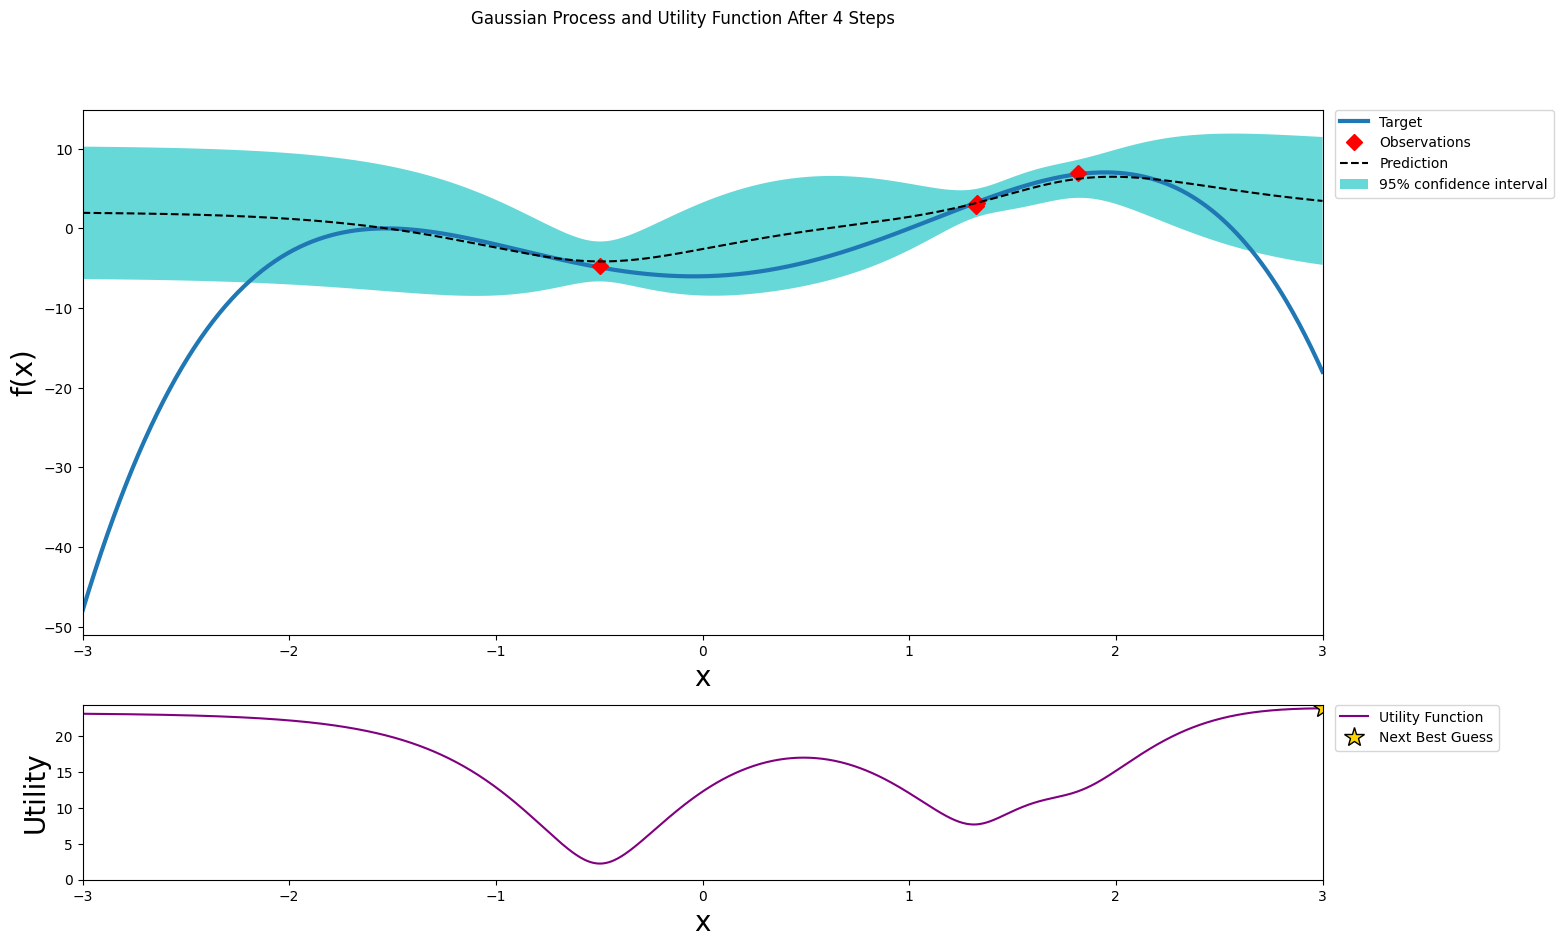

In [27]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

### After three steps of GP


|   iter    |  target   |     x     |
-------------------------------------
| 5         | -3.768    | 2.702     |


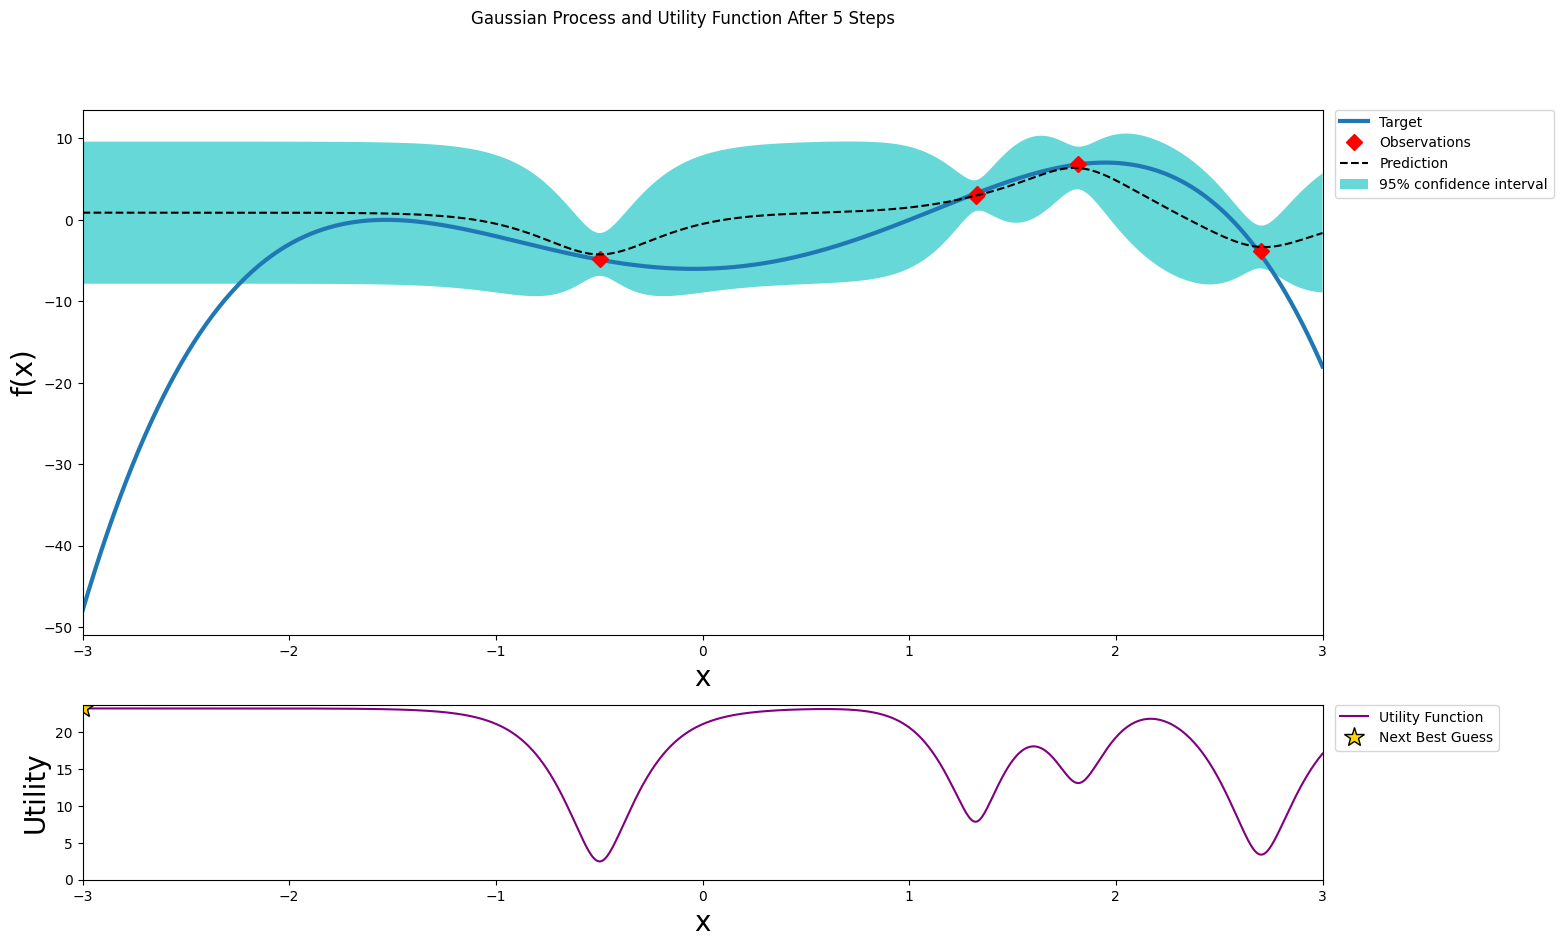

In [28]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

### After four steps of GP


|   iter    |  target   |     x     |
-------------------------------------
| 6         | 6.962     | 2.091     |


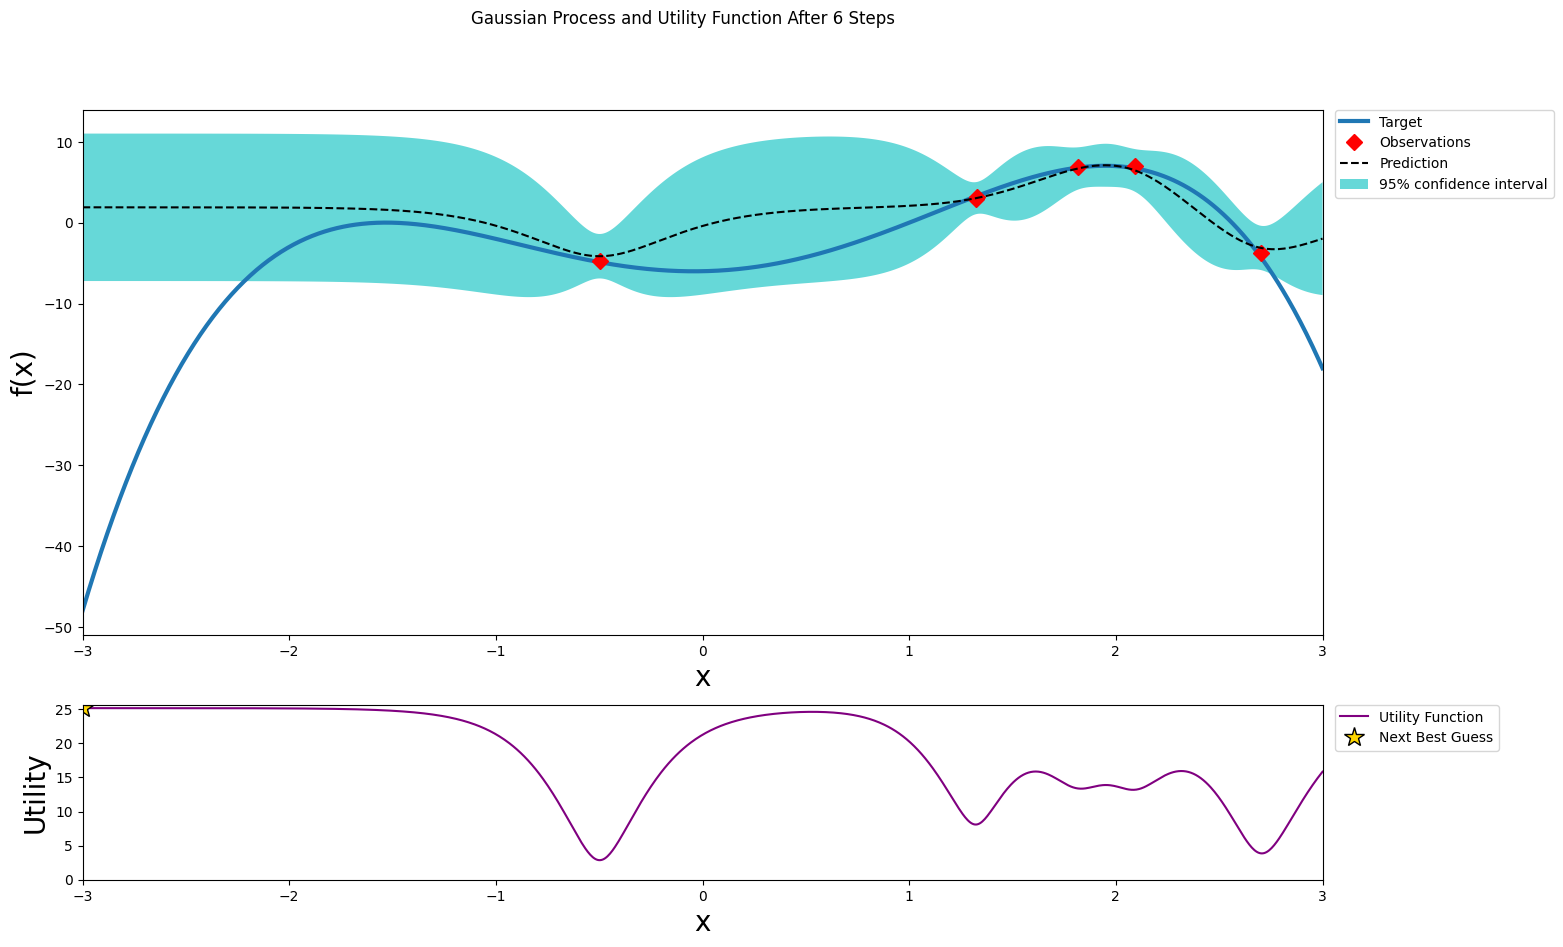

In [29]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

### After five steps of GP

|   iter    |  target   |     x     |
-------------------------------------
| 7         | -48.2     | -3.0      |


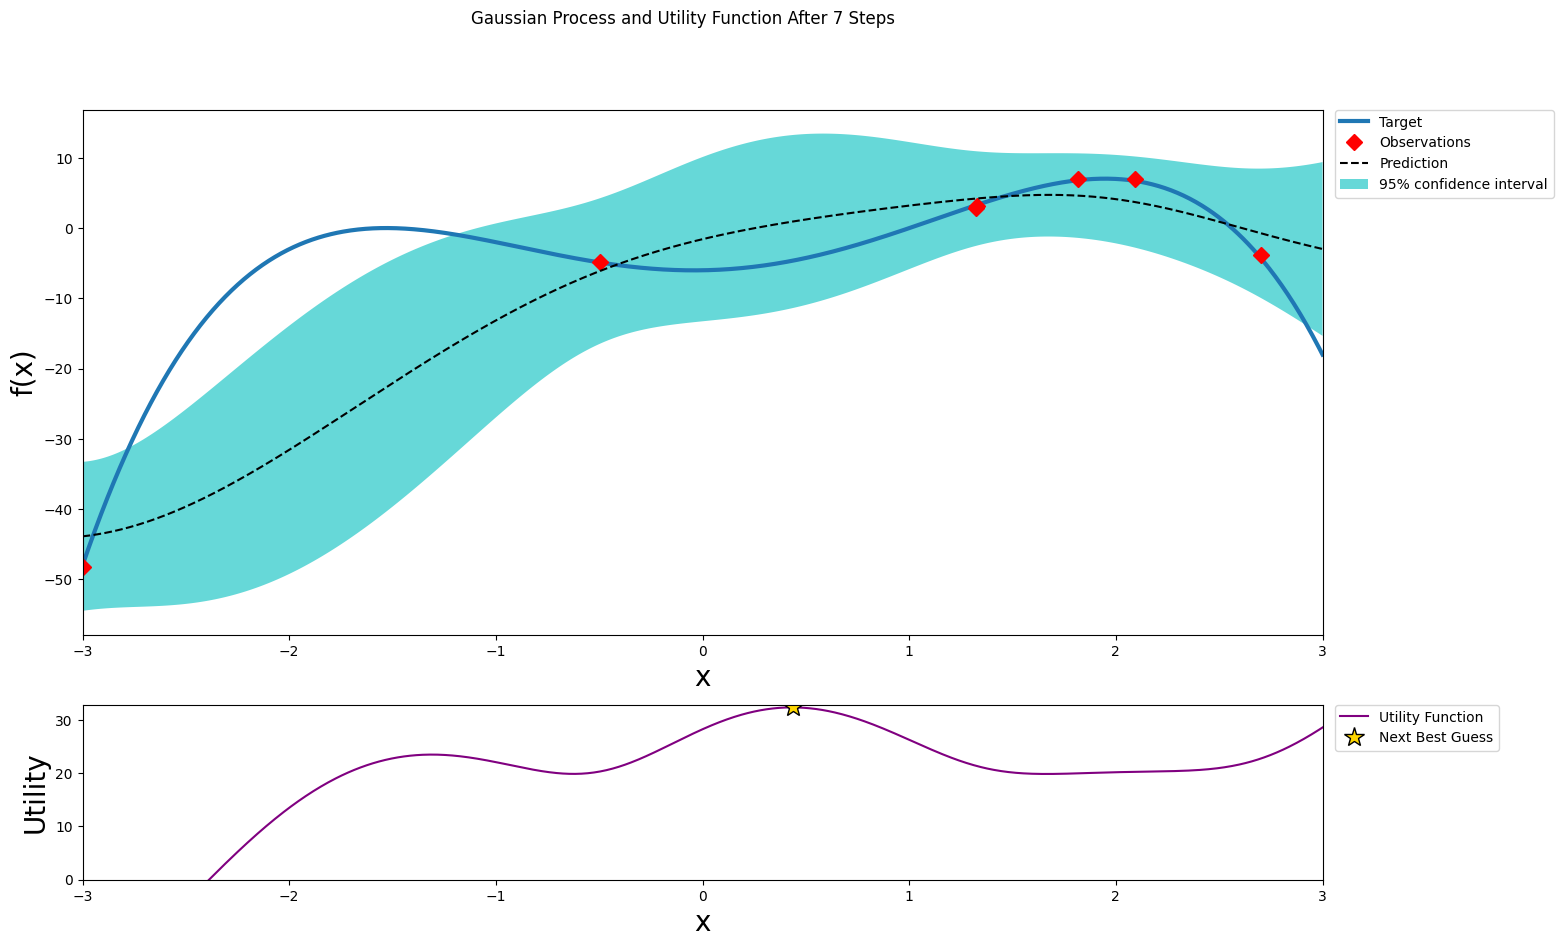

In [30]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

### After 20 steps of GP

|   iter    |  target   |     x     |
-------------------------------------
| 8         | -4.245    | 0.5255    |
| 9         | 7.067     | 1.898     |
| 10        | 6.863     | 1.882     |
| 11        | 6.836     | 1.826     |
| 12        | 5.519     | 2.063     |
| 13        | 5.593     | 1.656     |
| 14        | -17.13    | 3.0       |
| 15        | -0.4036   | -1.26     |
| 16        | 6.684     | 2.148     |
| 17        | 6.59      | 1.713     |
| 18        | 6.825     | 2.11      |
| 19        | 6.732     | 1.774     |
| 20        | 7.411     | 2.07      |
| 21        | 7.244     | 1.887     |
| 22        | 5.644     | 2.134     |
| 23        | 6.125     | 1.734     |
| 24        | 6.734     | 1.926     |
| 25        | 8.215     | 1.926     |
| 26        | 7.094     | 1.931     |
| 27        | 6.928     | 1.691     |


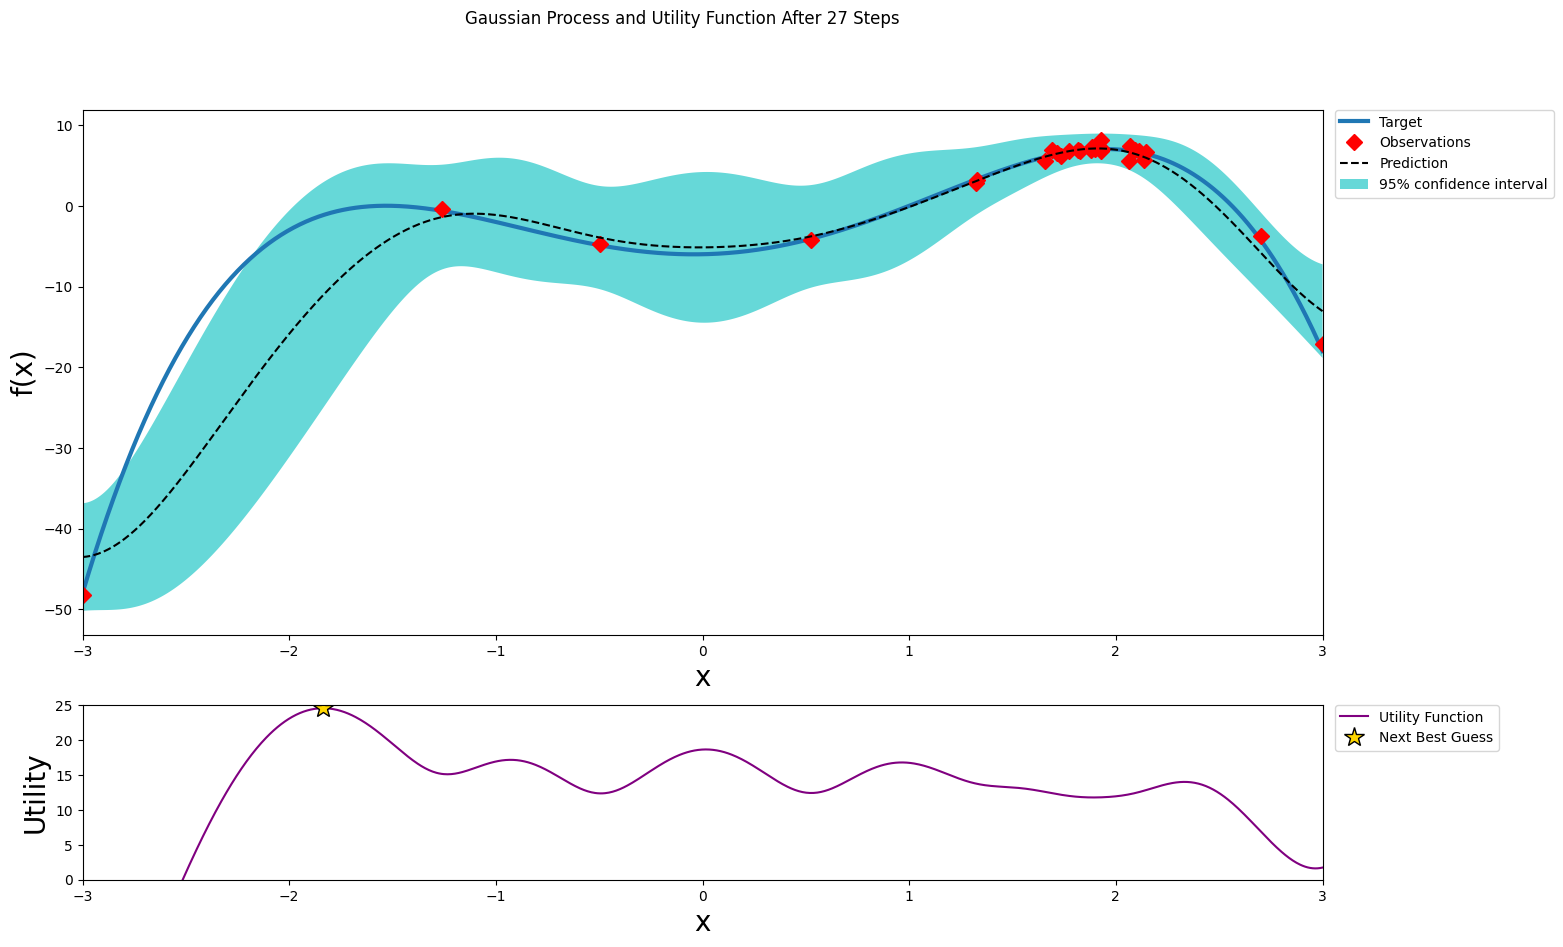

In [31]:
optimizer.maximize(init_points=0, n_iter=20)
plot_gp(optimizer, x, y)